In [1]:
from datetime import datetime
from itertools import combinations

import pandas as pd
import numpy as np

from arch import arch_model
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# df = pd.read_csv('./abcabcabc')
# df = pd.DataFrame(data=[list(l) for l in df.index[1:]], columns=df.index[0])
# df['close'] = df['close'].astype(float)
# df['date'] = df['date'].apply(lambda x: datetime(int(x[:4]), int(x[5:7]), int(x[8:10]), int(x[11:13])))
# df.set_index(keys='date', inplace=True)

# df = df[['symbol', 'close']]
# df['close'].plot()

## Import Prices and Calculate Log Returns

In [2]:
def loadPriceRet(path, columns, period=("04-2020", "12-2020")):
    """Function to load price and calculate log returns"""
    
    df = pd.read_csv(path)
    
    df.index = df['Date'].apply(lambda x: datetime(int(x[:4]), int(x[5:7]), int(x[-2:])))
    
    colToDrop = [col for col in df.columns if col not in columns]
    df.drop(columns=colToDrop, inplace=True)
    
    retSeries = (np.log(df['Adj Close'] / df['Adj Close'].shift(1))) * 100
    df['Log Returns'] = retSeries
    
    df.dropna(inplace=True)
    
    df = df[period[0]:period[1]]
    
    return df

In [3]:
eqy = loadPriceRet('./EWC.csv', columns=['Adj Close'])
gld = loadPriceRet('./GLD.csv', columns=['Adj Close'])
btc = loadPriceRet('./BTC-USD.csv', columns=['Adj Close'])

## Calculate Daily Returns

In [4]:
eqyDRet = eqy['Log Returns'].describe()['mean']
gldDRet = gld['Log Returns'].describe()['mean']
btcDRet = btc['Log Returns'].describe()['mean']

print('Daily Returns of EWC: {:.4f}%'.format(eqyDRet))
print('Daily Returns of GLD: {:.4f}%'.format(gldDRet))
print('Daily Returns of BTC: {:.4f}%'.format(btcDRet))

Daily Returns of EWC: 0.1967%
Daily Returns of GLD: 0.0961%
Daily Returns of BTC: 0.5473%


## Data Summaries (20-Day Moving Average)

In [5]:
def rollingMean(path, smaWindow=20, period=("04-2020", "12-2020")):
    
    df = loadPriceRet(path, columns=['Adj Close'], period=("01-2020", "12-2020"))
    
    rollMean = df['Adj Close'].rolling(smaWindow).mean()
    
    df['Rolling Mean'] = rollMean
    
    df = df[period[0]:period[1]]
    
    return df

In [6]:
eqy = rollingMean('./EWC.csv')
gld = rollingMean('./GLD.csv')
btc = rollingMean('./BTC-USD.csv')

## Graphing Moving Averages

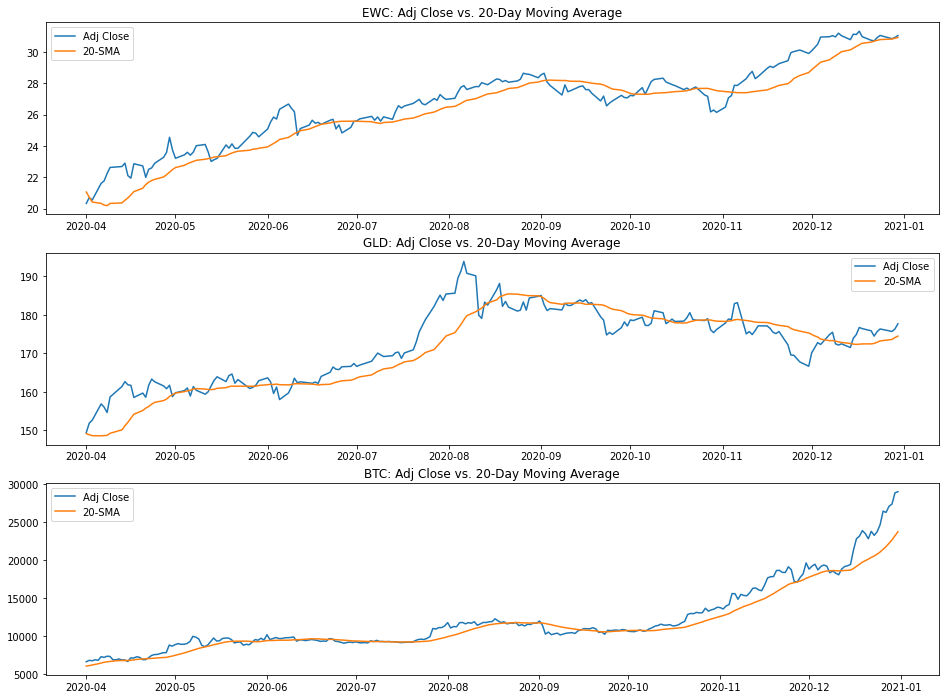

In [94]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 12))

axes[0].plot(eqy['Adj Close'], label="Adj Close")
axes[0].plot(eqy['Rolling Mean'], label="20-SMA")
axes[0].set_title("EWC: Adj Close vs. 20-Day Moving Average")
axes[0].legend()

axes[1].plot(gld['Adj Close'], label="Adj Close")
axes[1].plot(gld['Rolling Mean'], label="20-SMA")
axes[1].set_title("GLD: Adj Close vs. 20-Day Moving Average")
axes[1].legend()

axes[2].plot(btc['Adj Close'], label="Adj Close")
axes[2].plot(btc['Rolling Mean'], label="20-SMA")
axes[2].set_title("BTC: Adj Close vs. 20-Day Moving Average")
axes[2].legend()

plt.show()

### Graphing Prices (GLD vs. EWC)

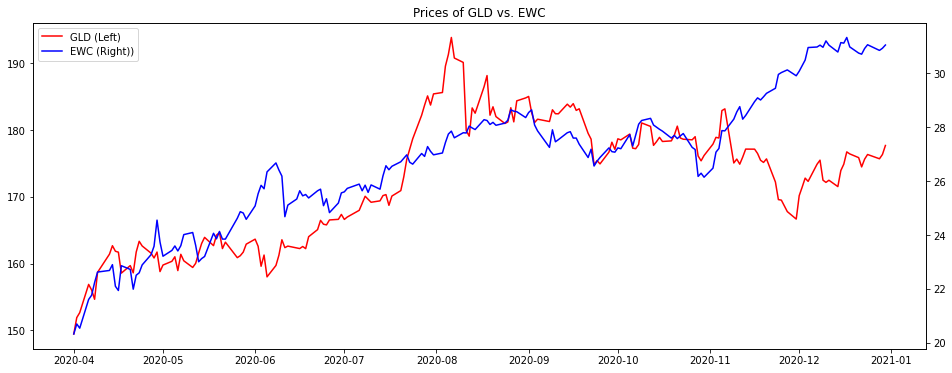

In [8]:
fig, ax = plt.subplots(figsize=(16, 6))
ax2 = plt.twinx()

ax.plot(gld['Adj Close'], label="GLD (Left)", c="r")
ax2.plot(eqy['Adj Close'], label='EWC (Right))', c="b")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines + lines2, labels + labels2, loc="upper left")

plt.title("Prices of GLD vs. EWC")
plt.show()

### Graphing Prices (GLD vs. BTC)

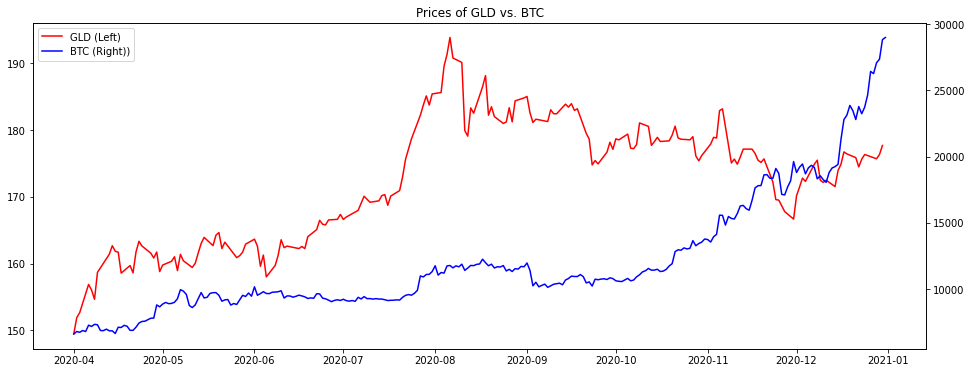

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))
ax2 = plt.twinx()

ax.plot(gld['Adj Close'], label="GLD (Left)", c="r")
ax2.plot(btc['Adj Close'], label="BTC (Right))", c="b")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines + lines2, labels + labels2, loc="upper left")

plt.title("Prices of GLD vs. BTC")
plt.show()

### Graphing Prices (EWC vs. BTC)

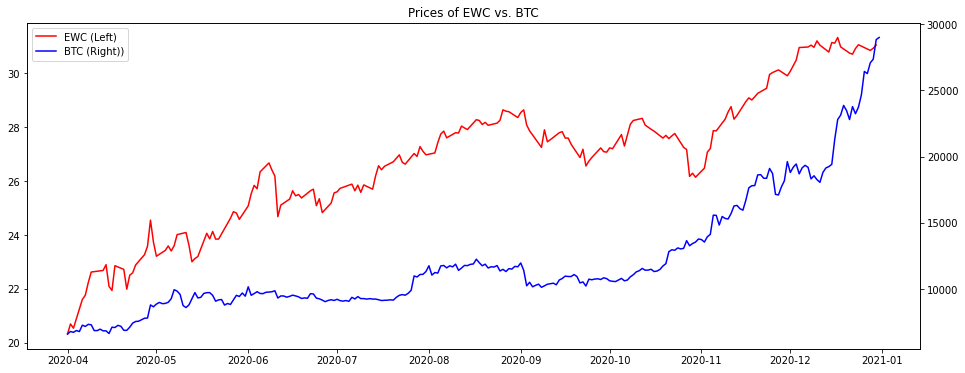

In [10]:
fig, ax = plt.subplots(figsize=(16, 6))
ax2 = plt.twinx()

ax.plot(eqy['Adj Close'], label="EWC (Left)", c="r")
ax2.plot(btc['Adj Close'], label="BTC (Right))", c="b")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines + lines2, labels + labels2, loc="upper left")

plt.title("Prices of EWC vs. BTC")
plt.show()

## Fitting GARCH Model

In [99]:
garchMDL = arch_model(y=gld['Log Returns'], vol='GARCH', p=1, q=1)
garchMDL = garchMDL.fit()
print(garchMDL.summary())

garchUncondVar = garchMDL.params['omega'] / (1 - garchMDL.params['alpha[1]'] - garchMDL.params['beta[1]'])
print("GARCH Unconditional Variance: {:.4f}".format(garchUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 286.7444885299979
Iteration:      2,   Func. Count:     16,   Neg. LLF: 286.6909746550908
Iteration:      3,   Func. Count:     25,   Neg. LLF: 286.5678797415104
Iteration:      4,   Func. Count:     34,   Neg. LLF: 286.521066567867
Iteration:      5,   Func. Count:     42,   Neg. LLF: 286.4872076285187
Iteration:      6,   Func. Count:     48,   Neg. LLF: 286.48644244360815
Iteration:      7,   Func. Count:     54,   Neg. LLF: 286.4863469614729
Iteration:      8,   Func. Count:     60,   Neg. LLF: 286.4863444015873
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 286.48634440178955
            Iterations: 8
            Function evaluations: 60
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log Returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:  

## Fitting GARCH-M Model

In [100]:
garchMMDL = arch_model(y=gld['Log Returns'], mean='constant', vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()

# Get squared residual and feed back to arch model?!
squaredRes = np.power(garchMMDL.resid, 2)
garchMMDL = arch_model(y=gld['Log Returns'], x=squaredRes, vol='GARCH', p=1, q=1)
garchMMDL = garchMMDL.fit()
print(garchMMDL.summary())

garchMUncondVar = garchMMDL.params['omega'] / (1 - garchMMDL.params['alpha[1]'] - garchMMDL.params['beta[1]'])
print("GARCH-M Unconditional Variance: {:.4f}".format(garchMUncondVar))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 286.7444885299979
Iteration:      2,   Func. Count:     16,   Neg. LLF: 286.6909746550908
Iteration:      3,   Func. Count:     25,   Neg. LLF: 286.5678797415104
Iteration:      4,   Func. Count:     34,   Neg. LLF: 286.521066567867
Iteration:      5,   Func. Count:     42,   Neg. LLF: 286.4872076285187
Iteration:      6,   Func. Count:     48,   Neg. LLF: 286.48644244360815
Iteration:      7,   Func. Count:     54,   Neg. LLF: 286.4863469614729
Iteration:      8,   Func. Count:     60,   Neg. LLF: 286.4863444015873
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 286.48634440178955
            Iterations: 8
            Function evaluations: 60
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      6,   Neg. LLF: 286.7444885299979
Iteration:      2,   Func. Count:     16,   Neg. LLF: 286.6909746550908
Iteration:      3,   Func. Count:     25,   Neg. LLF: 286.5678797415104

## Fitting TGARCH Model

In [91]:
tgarchMDL = arch_model(y=gld['Log Returns'], vol='GARCH', p=1, q=1, dist='studentst')
tgarchMDL = tgarchMDL.fit()
print(tgarchMDL.summary())

tgarchUncondVar = tgarchMDL.params['omega'] / (1 - tgarchMDL.params['alpha[1]'] - tgarchMDL.params['beta[1]'])
print("TGARCH Unconditional Variance: {:.4f}".format(tgarchUncondVar))

Iteration:      1,   Func. Count:      7,   Neg. LLF: 276.0025413429461
Iteration:      2,   Func. Count:     17,   Neg. LLF: 275.6334828529477
Iteration:      3,   Func. Count:     27,   Neg. LLF: 275.61683265453894
Iteration:      4,   Func. Count:     36,   Neg. LLF: 275.5425679748238
Iteration:      5,   Func. Count:     44,   Neg. LLF: 275.23714677456115
Iteration:      6,   Func. Count:     52,   Neg. LLF: 275.1089211476137
Iteration:      7,   Func. Count:     60,   Neg. LLF: 274.96607010378546
Iteration:      8,   Func. Count:     68,   Neg. LLF: 274.8916784095426
Iteration:      9,   Func. Count:     76,   Neg. LLF: 274.8681219472096
Iteration:     10,   Func. Count:     83,   Neg. LLF: 274.86562677940657
Iteration:     11,   Func. Count:     90,   Neg. LLF: 274.8655078333358
Iteration:     12,   Func. Count:     98,   Neg. LLF: 274.8655035240995
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 274.86550352409273
            Iterations

## Fitting EGARCH Model

In [92]:
egarchMDL = arch_model(y=gld['Log Returns'], mean='zero', vol='EGARCH', p=1, q=1)
egarchMDL = egarchMDL.fit()
print(egarchMDL.summary())

egarchUncondVar = egarchMDL.params['omega'] / (1 - egarchMDL.params['alpha[1]'] - egarchMDL.params['beta[1]'])
print("EGARCH Unconditional Variance: {:.4f}".format(egarchUncondVar))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 286.5976755205951
Iteration:      2,   Func. Count:     14,   Neg. LLF: 286.58305902699595
Iteration:      3,   Func. Count:     21,   Neg. LLF: 286.54101567675144
Iteration:      4,   Func. Count:     28,   Neg. LLF: 286.53968654459396
Iteration:      5,   Func. Count:     33,   Neg. LLF: 286.53293179832
Iteration:      6,   Func. Count:     38,   Neg. LLF: 286.53279768010736
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 286.5327970466541
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.005
Vol Model:                     EGARCH   Log-Likelihood:               -286.533
Distribution:                  Normal   AI

## Fitting IGARCH Model

In [93]:
igarchMDL = arch_model(y=gld['Log Returns'].cumsum(), mean='zero', vol='GARCH', p=1, q=1)
igarchMDL = igarchMDL.fit()
print(igarchMDL.summary())
print("Unconditional Variance of IGARCH is undefined (Tsay)")

Iteration:      1,   Func. Count:      5,   Neg. LLF: 773.7387064535665
Iteration:      2,   Func. Count:     10,   Neg. LLF: 772.0317054636848
Iteration:      3,   Func. Count:     17,   Neg. LLF: 772.028603085408
Iteration:      4,   Func. Count:     24,   Neg. LLF: 772.0165833050958
Iteration:      5,   Func. Count:     29,   Neg. LLF: 772.0131042442064
Iteration:      6,   Func. Count:     34,   Neg. LLF: 772.0089254023757
Iteration:      7,   Func. Count:     39,   Neg. LLF: 772.0054444182264
Iteration:      8,   Func. Count:     44,   Neg. LLF: 771.990141237116
Iteration:      9,   Func. Count:     49,   Neg. LLF: 771.9578966932115
Iteration:     10,   Func. Count:     54,   Neg. LLF: 771.9545523442271
Iteration:     11,   Func. Count:     59,   Neg. LLF: 771.9543210108603
Iteration:     12,   Func. Count:     64,   Neg. LLF: 771.9543190081281
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 771.9543190015976
            Iterations: 12
  

## Assessing Stationarity

In [20]:
def stationarityTest(data):
    
    _, adfP, _, _, _,_ = sm.tsa.adfuller(data, maxlag=0)
    _, kpssP, _, _    = sm.tsa.kpss(data, nlags=0)

    if (adfP <= 0.05) & (kpssP > 0.05):
        print("Process is stationary!")
    elif ((adfP <= 0.05) & (kpssP <= 0.05)) | ((adfP > 0.05) & (kpssP > 0.05)):
        print("Process may or may not be stationary")
    else:
        print("Process is NOT stationary!")

In [21]:
stationarityTest(eqy['Adj Close'])
stationarityTest(gld['Adj Close'])
stationarityTest(btc['Adj Close'])

Process is NOT stationary!
Process is NOT stationary!
Process is NOT stationary!


/Users/elroy/Desktop/Coding/Python/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/elroy/Desktop/Coding/Python/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/elroy/Desktop/Coding/Python/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [101]:
stationarityTest(eqy['Log Returns'])
stationarityTest(gld['Log Returns'])
stationarityTest(btc['Log Returns'])

Process is stationary!
Process is stationary!
Process is stationary!


/Users/elroy/Desktop/Coding/Python/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/elroy/Desktop/Coding/Python/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/elroy/Desktop/Coding/Python/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Engle-Granger Test for cointegration

In [51]:
def cointTest(x, y):
    
    _, egts, _ = coint(x, y, maxlag=0)
    
    if egts <= 0.05:
        
        print("Prices pair are cointegrated")
    
    else:
        
        print("Prices pair are NOT cointegrated")

In [52]:
eqyQ2 = eqy['04-2020':'06-2020']
gldQ2 = gld['04-2020':'06-2020']
btcQ2 = btc.loc[eqyQ2.index, :]

eqyQ3 = eqy['07-2020':'09-2020']
gldQ3 = gld['07-2020':'09-2020']
btcQ3 = btc.loc[eqyQ3.index, :]

#### Q2 Engle-Granger

In [53]:
cointTest(eqyQ2['Adj Close'], gldQ2['Adj Close'])
cointTest(eqyQ2['Adj Close'], btcQ2['Adj Close'])
cointTest(gldQ2['Adj Close'], btcQ2['Adj Close'])

Prices pair are NOT cointegrated
Prices pair are NOT cointegrated
Prices pair are NOT cointegrated


#### Q2 Johansen

In [55]:
johansen = coint_johansen(np.vstack((eqyQ2['Adj Close'], gldQ2['Adj Close'], btcQ2['Adj Close'])).T, 1, 0)

In [56]:
print(johansen.trace_stat)
print('==')
print(johansen.trace_stat_crit_vals)

[18.8577392   9.62492195  2.56268168]
==
[[32.0645 35.0116 41.0815]
 [16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


In [78]:
johansen.max_eig_stat

array([9.6276637 , 8.42823587, 2.04253335])

In [79]:
johansen.max_eig_stat_crit_vals

array([[21.8731, 24.2522, 29.2631],
       [15.0006, 17.1481, 21.7465],
       [ 2.7055,  3.8415,  6.6349]])

Johansen test seems to imply that there are no cointegrating pairs as well. Stats < Crit Values

#### Q3 Engle-Granger

In [54]:
cointTest(eqyQ3['Adj Close'], gldQ3['Adj Close'])
cointTest(eqyQ3['Adj Close'], btcQ3['Adj Close'])
cointTest(gldQ3['Adj Close'], btcQ3['Adj Close'])

Prices pair are NOT cointegrated
Prices pair are NOT cointegrated
Prices pair are NOT cointegrated


#### Q3 Johansen

In [59]:
johansen = coint_johansen(np.vstack((eqyQ3['Adj Close'], gldQ3['Adj Close'], btcQ3['Adj Close'])).T, 1, 0)

In [85]:
print(johansen.trace_stat)

[20.09843292 10.47076922  2.04253335]


In [86]:
print(johansen.trace_stat_crit_vals)

[[32.0645 35.0116 41.0815]
 [16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


Johansen test seems to imply that there are no cointegrating pairs as well. Stats < Crit Values

No pairs are cointegrated and therefore we are unable to identify if Q2 cointegration tests help predict coefficients from Q3 cointegration